# Facebook Friend Recommendation System-Dhilip vasanth

# Problem statement:

Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)

# Data Overview:

Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting
data contains two columns source and destination eac edge in graph - Data columns (total 2 columns):
- source_node int64
- destination_node int64

# Business objectives and constraints:

1. No low-latency requirement.

2. Probability of prediction is useful to recommend highest probability links

# Performance metric for supervised learning:

1. Both precision and recall is important so F1 score is good choice

2. Confusion matrix

# Import the libraries 

In [116]:
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import datetime 
import time 
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import math
import pickle
import os
import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from tqdm import tqdm
from scipy.sparse.linalg import svds, eigs
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.metrics import roc_curve, auc
import xgboost
from sklearn.linear_model import SGDClassifier

# Loading the dataset

In [2]:
df=pd.read_csv("train_woheader-1.csv")


In [3]:
g=nx.read_edgelist('train_woheader-1.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(g))


Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


# Visualization the dataset into graph

In [106]:
pd.read_csv("train_woheader-1.csv",nrows=50).to_csv("sample.csv",header=False,index=False)

C:\Users\fsdq-\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\fsdq-\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes
C:\Users\fsdq-\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes
C:\Users\fsdq-\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.ite

Name: 
Type: DiGraph
Number of nodes: 66
Number of edges: 50
Average in degree:   0.7576
Average out degree:   0.7576


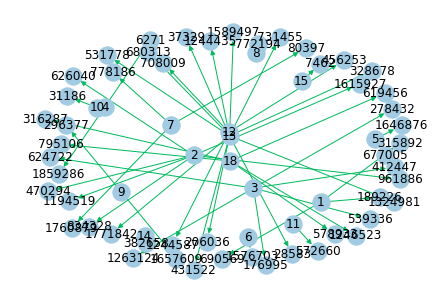

In [5]:
subgraph=nx.read_edgelist("sample.csv",delimiter=',',create_using=nx.DiGraph(),nodetype=int)
pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color="#A0CBE2",edge_color="#00bb5e",width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph_sample.pdf")
print(nx.info(subgraph))

# Exploratory Data Analysis

In [6]:
print("The number of unique person:{}".format(len(g.nodes())))

The number of unique person:1862220


## No of followers for each person

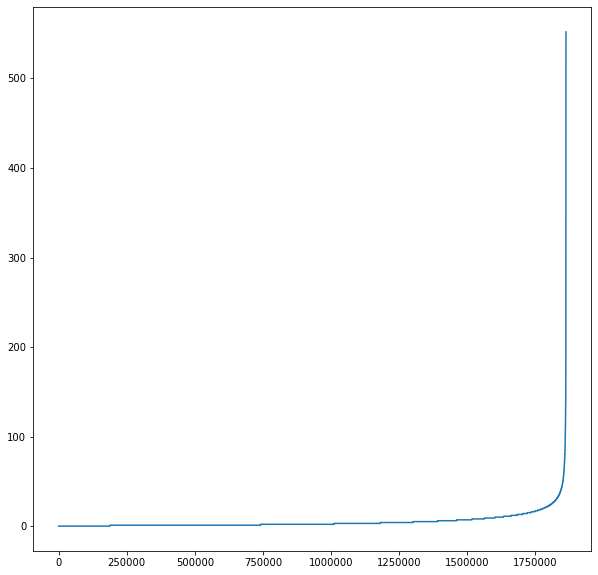

In [7]:
from collections import Counter

followee=dict(g.in_degree())
followee_counter=list(Counter(followee).values())
followee_counter.sort()
plt.figure(figsize=(10,10))
plt.plot(followee_counter)
plt.show()

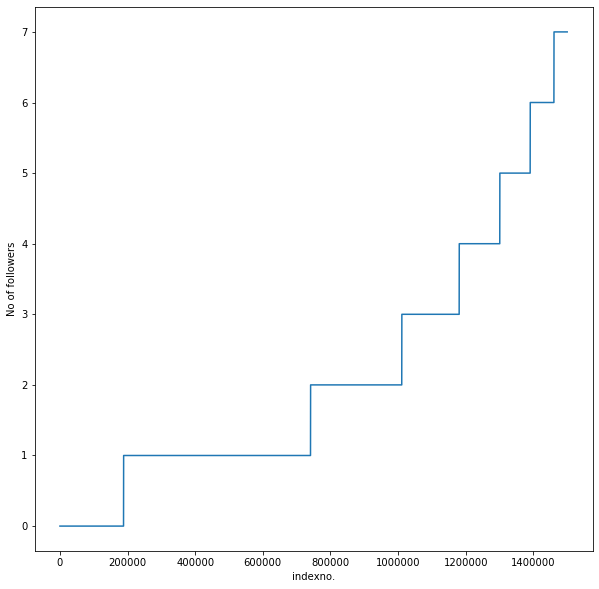

In [8]:
plt.figure(figsize=(10,10))
plt.plot(followee_counter[0:1500000])
plt.xlabel("indexno.")
plt.ylabel("No of followers")
plt.show()

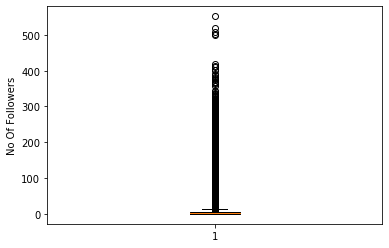

In [9]:
plt.boxplot(followee_counter)
plt.ylabel('No Of Followers')
plt.show()

## No of people each person is following


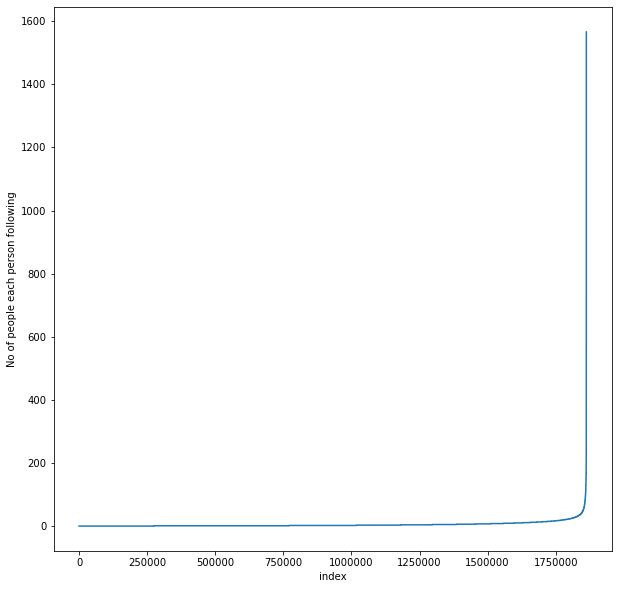

In [10]:
follower=dict(g.out_degree())
follower_counter=list(Counter(follower).values())
follower_counter.sort()
plt.figure(figsize=(10,10))
plt.plot(follower_counter)
plt.ylabel("No of people each person following")
plt.xlabel("index")
plt.show()

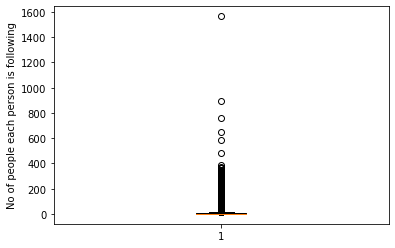

In [11]:
plt.boxplot(follower_counter)
plt.ylabel("No of people each person is following")
plt.show()

In [12]:
print('No of persons those are not following anyone are' ,sum(np.array(follower_counter)==0))

No of persons those are not following anyone are 274512


In [13]:
print('No of persons having zero followers are' ,sum(np.array(followee_counter)==0))

No of persons having zero followers are 188043


## Both follower and following

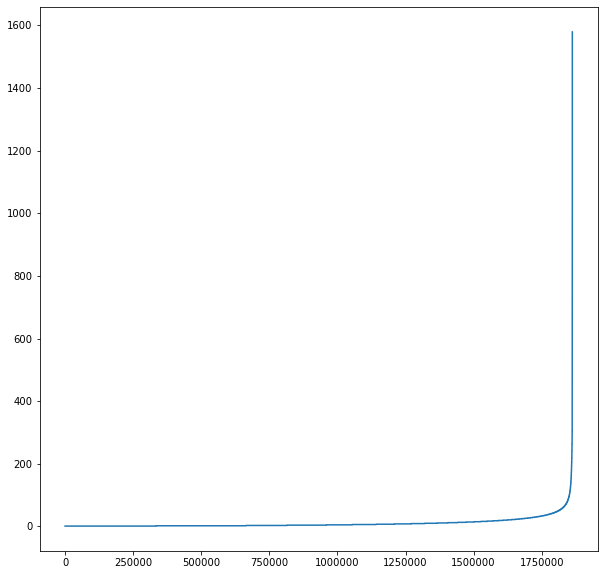

In [14]:
from collections import Counter

followee=dict(g.in_degree())
follower=dict(g.out_degree())
followee_counter=Counter(followee)
follower_counter=Counter(follower)
followerandfollowee=followee_counter+follower_counter
both=np.array(list(followerandfollowee.values()))
a=sorted(both)

plt.figure(figsize=(10,10))
plt.plot(a)
plt.show()

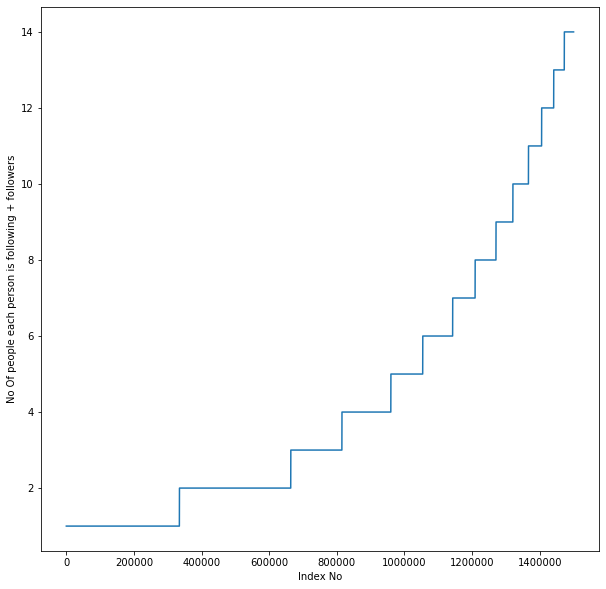

In [15]:
plt.figure(figsize=(10,10))
plt.plot(a[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

## Posing a problem as classification problem

In [16]:
missing_edges = pickle.load(open('missing_edges_final.p','rb'))
print("No. of mising edges:",len(missing_edges))
len(missing_edges)

No. of mising edges: 9437519


9437519

# Train and Test data split:

Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

In [17]:
from sklearn.model_selection import train_test_split
df_positive=pd.read_csv("train.csv")
df_negative=pd.DataFrame(list(missing_edges),columns=["source_node","destination_node"])
x_trainpos,x_testpos,y_trainpos,y_testpos=train_test_split(df_positive,np.ones(len(df_positive)),test_size=0.2,random_state=9)
x_trainneg,x_testneg,y_trainneg,y_testneg=train_test_split(df_negative,np.zeros(len(df_positive)),test_size=0.2,random_state=9)


In [18]:
print('='*60)
print("Number of nodes in the train data graph with edges", x_trainpos.shape[0])
print("Number of nodes in the train data graph without edges", x_trainneg.shape[0])
print('='*60)
print("Number of nodes in the test data graph with edges", x_testpos.shape[0])
print("Number of nodes in the test data graph without edges", x_testneg.shape[0])


Number of nodes in the train data graph with edges 7550015
Number of nodes in the train data graph without edges 7550015
Number of nodes in the test data graph with edges 1887504
Number of nodes in the test data graph without edges 1887504


In [19]:
train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
test_graph=nx.read_edgelist('test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))
print(nx.info(test_graph))

train_nodes_pos = set(train_graph.nodes())
test_nodes_pos = set(test_graph.nodes())

trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
trY_teN = len(train_nodes_pos - test_nodes_pos)
teY_trN = len(test_nodes_pos - train_nodes_pos)

print('no of people common in train and test -- ',trY_teY)
print('no of people present in train but not present in test -- ',trY_teN)

print('no of people present in test but not present in train -- ',teY_trN)
print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399
Name: 
Type: DiGraph
Number of nodes: 1144623
Number of edges: 1887504
Average in degree:   1.6490
Average out degree:   1.6490
no of people common in train and test --  1063125
no of people present in train but not present in test --  717597
no of people present in test but not present in train --  81498
 % of people not there in Train but exist in Test in total Test data are 7.1200735962845405 %


In [20]:
X_train =x_trainpos.append(x_trainneg,ignore_index=True)
y_train = np.concatenate((y_trainpos,y_trainneg))
X_test = x_testpos.append(x_testneg,ignore_index=True)
y_test = np.concatenate((y_testpos,y_testneg))

In [21]:
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)

Data points in train data (15100030, 2)
Data points in test data (3775008, 2)
Shape of traget variable in train (15100030,)
Shape of traget variable in test (3775008,)


# 2.0Feature Engineering

## 2.1Jaccard Distance:



### 2.1.1jaccard Distance for folllowee

In [22]:
train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


In [23]:
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [24]:
jaccard_for_followees(5000,600)

0.0

### 2.1.2jaccard Distance for followers

In [25]:
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [26]:
jaccard_for_followers(500,700)

0.0

## 2.2Cosine Distance

### 2.2.1Cosine distance for followees

In [27]:
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [28]:
cosine_for_followees(400,500)

0.0

### 2.2.2Cosine Distance for followers

In [29]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [30]:
cosine_for_followers(4000,60000)

0.0

## 2.3Page rank features

In [31]:
pr = nx.pagerank(train_graph, alpha=0.85)
print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))

min 1.6556497245737814e-07
max 2.7098251341935827e-05
mean 5.615699699389075e-07


In [32]:
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

5.615699699389075e-07


## 2.4Shortest path

In [33]:
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

In [34]:
compute_shortest_path_length(30000,600)

-1

In [35]:
compute_shortest_path_length(10999,98)

10

## 2.5Checking for same community

In [36]:
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [37]:
belongs_to_same_wcc(3,700)

1

In [38]:
belongs_to_same_wcc(9899000,908980)

0

 ## 2.6Adamic/Adar Index:

In [39]:
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [40]:
calc_adar_in(890,900)

0

## 2.7Is person was following back:

In [41]:
def followback(a,b):
  if train_graph.has_edge(b,a):
    return 1
  else:
    return 0

In [42]:
followback(100,9)

0

## 2.8Katz Centrality:

In [43]:
katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.0007313532484065916
max 0.003394554981699122
mean 0.0007483800935562018


In [44]:
mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0007483800935562018


## 2.9Hits Score

In [45]:
hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min 0.0
max 0.004868653378780953
mean 5.615699699344123e-07


# 3.0Featurization

## Reading a sample of Data from both train and test

In [46]:
import random
filename = "data/after_eda/train_after_eda.csv"
n_train =  15100028
s = 100000
skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))

In [47]:
filename = "data/after_eda/test_after_eda.csv"
n_test = 3775006
s = 50000 #desired sample size
skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))

In [48]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 15100028
Number of rows we are going to elimiate in train data are 15000028
Number of rows in the test data file: 3775006
Number of rows we are going to elimiate in test data are 3725006


## 3.1 Train dataset

In [49]:
df_final_train = pd.read_csv('train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

Our train matrix size  (100002, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,1228116,471233,1


##  3.2 Test dataset

In [50]:
df_final_test = pd.read_csv('test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our test matrix size  (50002, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,104114,57653,1


## Adding a set of features

__we will create these each of these features for both train and test data points__
<ol>
<li>jaccard_followers</li>
<li>jaccard_followees</li>
<li>cosine_followers</li>
<li>cosine_followees</li>
<li>num_followers_s</li>
<li>num_followees_s</li>
<li>num_followers_d</li>
<li>num_followees_d</li>
<li>inter_followers</li>
<li>inter_followees</li>
<li>adar index</li>
<li>is following back</li>
<li>belongs to same weakly connect components</li>
<li>shortest path between source and destination</li>
<li>Weight Features
    <ul>
        <li>weight of incoming edges</li>
        <li>weight of outgoing edges</li>
        <li>weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges * weight of outgoing edges</li>
        <li>2*weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges + 2*weight of outgoing edges</li>
    </ul>
</li>
<li>Page Ranking of source</li>
<li>Page Ranking of dest</li>
<li>katz of source</li>
<li>katz of dest</li>
<li>hubs of source</li>
<li>hubs of dest</li>
<li>authorities_s of source</li>
<li>authorities_s of dest</li>
<li>preferential_attachment</li>
<li>svd.dot_features</li>
<li>SVD features for both source and destination</li>
</ol>

#### jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followers_d,num_followees_d,inter_followers,inter_followees

In [51]:
df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    

        #mapping jaccrd followers to train and test data
df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping jaccrd followees to train and test data
df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)

In [52]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [53]:
df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
hdf = HDFStore('storage_sample_stage1.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()
df_final_train = read_hdf('storage_sample_stage1.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_sample_stage1.h5', 'test_df',mode='r')

#### adar index,is following back,belongs to same weakly connect components,shortest path between source and destination

In [54]:
 #mapping adar index on train
df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping adar index on test
df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping followback or not on train
df_final_train['follows_back'] = df_final_train.apply(lambda row: followback(row['source_node'],row['destination_node']),axis=1)

    #mapping followback or not on test
df_final_test['follows_back'] = df_final_test.apply(lambda row: followback(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping same component of wcc or not on train
df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    ##mapping same component of wcc or not on train
df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    
    #--------------------------------------------------------------------------------------------------------
    #mapping shortest path on train 
df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    #mapping shortest path on test
df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

hdf = HDFStore('storage_sample_stage2.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()
df_final_train = read_hdf('storage_sample_stage2.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_sample_stage2.h5', 'test_df',mode='r')

In [55]:
#weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|████████████████████████████████████████████████████████████████████| 1780722/1780722 [00:13<00:00, 127491.09it/s]


#### weight features

In [56]:
df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights
df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

#### Page Ranking of source,Page Ranking of dest,katz of source,katz of dest,hubs of source,hubs of dest,authorities_s of source,authorities_s of dest 

In [57]:
df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

    #Hits algorithm score for source and destination in Train and test
    #if anything not there in train graph then adding 0
df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
    #================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================

hdf = HDFStore('storage_sample_stage3.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()
df_final_train = read_hdf('storage_sample_stage3.h5', 'train_df',mode='r')
df_final_test = read_hdf('storage_sample_stage3.h5', 'test_df',mode='r')

#### SVD features,SVD dot features 

In [58]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [59]:
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [60]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [61]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [62]:

    #===================================================================================================
df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

hdf = HDFStore('storage_sample_stage4.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()

#### SVD dot train features

In [63]:
s1=df_final_train['svd_u_s_1']
s2=df_final_train['svd_u_s_2']
s3=df_final_train['svd_u_s_3']
s4=df_final_train['svd_u_s_4']
s5=df_final_train['svd_u_s_5']
s6=df_final_train['svd_u_s_6']
s7=df_final_train['svd_v_s_1']
s8=df_final_train['svd_v_s_2']
s9=df_final_train['svd_v_s_3']
s10=df_final_train['svd_v_s_4']
s11=df_final_train['svd_v_s_5']
s12=df_final_train['svd_v_s_6']
d1=df_final_train['svd_u_d_1']
d2=df_final_train['svd_u_d_2']
d3=df_final_train['svd_u_d_3']
d4=df_final_train['svd_u_d_4']
d5=df_final_train['svd_u_d_5']
d6=df_final_train['svd_u_d_6']
d7=df_final_train['svd_v_d_1']
d8=df_final_train['svd_v_d_2']
d9=df_final_train['svd_v_d_3']
d10=df_final_train['svd_v_d_4']
d11=df_final_train['svd_v_d_5']
d12=df_final_train['svd_v_d_6']

In [64]:
c=[]
for i in range(len(s1)):
    a=[]
    b=[]
    a.append(s1[i])
    a.append(s2[i])
    a.append(s3[i])
    a.append(s4[i])
    a.append(s5[i])
    a.append(s6[i])
    a.append(s7[i])
    a.append(s8[i])
    a.append(s9[i])
    a.append(s10[i])
    a.append(s11[i])
    a.append(s12[i])
    b.append(s1[i])
    b.append(s2[i])
    b.append(s3[i])
    b.append(s4[i])
    b.append(s5[i])
    b.append(s6[i])
    b.append(s7[i])
    b.append(s8[i])
    b.append(s9[i])
    b.append(s10[i])
    b.append(s11[i])
    b.append(s12[i])
    c.append(np.dot(a,b))
df_final_train["svd_dot"]=c

#### SVD dot test features

In [65]:
s1=df_final_test['svd_u_s_1']
s2=df_final_test['svd_u_s_2']
s3=df_final_test['svd_u_s_3']
s4=df_final_test['svd_u_s_4']
s5=df_final_test['svd_u_s_5']
s6=df_final_test['svd_u_s_6']
s7=df_final_test['svd_v_s_1']
s8=df_final_test['svd_v_s_2']
s9=df_final_test['svd_v_s_3']
s10=df_final_test['svd_v_s_4']
s11=df_final_test['svd_v_s_5']
s12=df_final_test['svd_v_s_6']
d1=df_final_test['svd_u_d_1']
d2=df_final_test['svd_u_d_2']
d3=df_final_test['svd_u_d_3']
d4=df_final_test['svd_u_d_4']
d5=df_final_test['svd_u_d_5']
d6=df_final_test['svd_u_d_6']
d7=df_final_test['svd_v_d_1']
d8=df_final_test['svd_v_d_2']
d9=df_final_test['svd_v_d_3']
d10=df_final_test['svd_v_d_4']
d11=df_final_test['svd_v_d_5']
d12=df_final_test['svd_v_d_6']

In [66]:
c=[]
for i in range(len(s1)):
    a=[]
    b=[]
    a.append(s1[i])
    a.append(s2[i])
    a.append(s3[i])
    a.append(s4[i])
    a.append(s5[i])
    a.append(s6[i])
    a.append(s7[i])
    a.append(s8[i])
    a.append(s9[i])
    a.append(s10[i])
    a.append(s11[i])
    a.append(s12[i])
    b.append(s1[i])
    b.append(s2[i])
    b.append(s3[i])
    b.append(s4[i])
    b.append(s5[i])
    b.append(s6[i])
    b.append(s7[i])
    b.append(s8[i])
    b.append(s9[i])
    b.append(s10[i])
    b.append(s11[i])
    b.append(s12[i])
    c.append(np.dot(a,b))
df_final_test["svd_dot"]=c

#### preferential attachment for train set

In [67]:
def preferent_attachment(a1,a2):
    preferential_follower=a1*a2
    return preferential_follower

In [68]:
df_final_train["preferential_attachment_followers"]=df_final_train.apply(lambda x: preferent_attachment(x["num_followers_s"],x["num_followers_d"]),axis=1)

In [69]:
df_final_train["preferential_attachment_followees"]=df_final_train.apply(lambda x: preferent_attachment(x["num_followees_s"],x["num_followees_d"]),axis=1)


In [70]:
df_final_test["preferential_attachment_followers"]=df_final_test.apply(lambda x: preferent_attachment(x["num_followers_s"],x["num_followers_d"]),axis=1)

In [71]:
df_final_test["preferential_attachment_followees"]=df_final_test.apply(lambda x: preferent_attachment(x["num_followees_s"],x["num_followees_d"]),axis=1)

In [87]:
df_train=df_final_train.drop("indicator_link",axis=1)
df_train.head()

,source_node,destination_node,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,...,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot,preferential_attachment_followers,preferential_attachment_followees
0,273084,1505602,0.000000,0.000000,0.000000,0.000000,11,6,15,8,...,1.719695e-14,-1.355368e-12,4.675314e-13,1.128583e-06,6.616687e-14,9.771075e-13,4.159935e-14,1.127247e-10,66.0,120.0
1,1228116,471233,0.068966,0.162162,0.022272,0.279751,14,48,23,20,...,1.110805e-16,-1.031744e-14,1.736398e-07,2.623467e-10,2.144795e-14,1.503898e-09,6.347201e-16,2.379574e-15,672.0,460.0
2,739876,852055,0.000000,0.000000,0.000000,0.000000,1,19,5,0,...,-2.265691e-22,-6.754018e-12,2.936545e-10,1.059854e-10,6.418263e-11,3.186242e-10,3.955842e-13,4.129516e-20,19.0,0.0
3,1390733,542070,0.000000,0.047619,0.000000,0.097590,6,17,7,15,...,7.321750e-17,-2.401772e-12,5.323082e-10,6.527964e-09,2.251989e-11,1.234854e-11,5.819293e-14,4.078292e-21,102.0,105.0
4,1069388,33126,0.000000,0.000000,0.000000,0.000000,20,21,25,9,...,2.422041e-10,-1.260282e-11,8.410746e-12,9.007327e-06,3.927170e-12,1.318969e-09,6.983724e-13,1.841166e-10,420.0,225.0


In [91]:
df_test=df_final_test.drop("indicator_link",axis=1)
df_test.head()

,source_node,destination_node,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,...,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot,preferential_attachment_followers,preferential_attachment_followees
0,848424,784690,0.052632,0.0,0.029161,0.0,6,14,6,9,...,5.535503e-14,-9.994076e-10,5.791913e-10,3.512350e-07,2.486660e-09,2.771146e-09,1.727671e-12,2.432749e-20,84.0,54.0
1,104114,57653,0.000000,0.0,0.000000,0.0,5,1,5,1,...,6.464185e-14,-1.039987e-13,4.101965e-13,7.984390e-06,4.688540e-14,2.855356e-13,2.813433e-14,3.451460e-13,5.0,5.0
2,1023305,1027793,0.000000,0.0,0.000000,0.0,21,49,19,33,...,2.564540e-10,-2.775532e-09,5.787856e-10,1.656781e-08,5.166967e-10,2.848540e-10,9.931389e-10,3.871546e-17,1029.0,627.0
3,673331,482741,0.000000,0.0,0.000000,0.0,11,5,13,11,...,3.114235e-16,-1.820043e-13,4.019880e-14,1.080250e-12,1.489487e-13,2.073316e-11,2.590965e-14,3.796558e-22,55.0,143.0
4,1810926,68478,0.000000,0.0,0.000000,0.0,1,2,0,4,...,1.220036e-14,-8.875337e-14,6.121848e-16,4.764359e-12,2.649267e-12,6.202674e-14,2.242097e-14,1.558595e-28,2.0,0.0


In [100]:
df_train.shape

(100002, 57)

In [115]:
df_test.shape

(50002, 57)

In [139]:
X_train,X_cv,y_train,y_t=train_test_split(df_train,y_train,test_size=0.4)

ValueError: Found input variables with inconsistent numbers of samples: [100002, 70001]

In [133]:
X_cv.shape

(30001, 57)

In [134]:
y_cv

NameError: name 'y_cv' is not defined

# Model implementation

## Hyper-parameter tuning using estimator in RandomForest

In [141]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [77]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Estimators =  10 Train Score 0.9278851670648126 test Score 0.9210326178806827
Estimators =  50 Train Score 0.9251594510513885 test Score 0.8979390296264491
Estimators =  100 Train Score 0.9225436664126202 test Score 0.9127032929751278
Estimators =  250 Train Score 0.9221816664928564 test Score 0.9133618318025988
Estimators =  400 Train Score 0.9221367040026698 test Score 0.9149677828245484


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

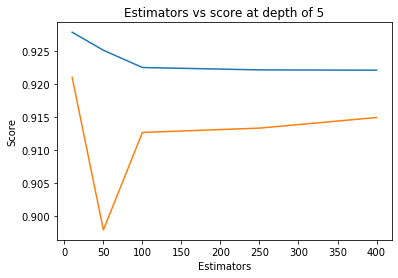

In [95]:
estimator=[10,50,100,250,400]
train_scores=[]
test_scores=[]
for i in estimator:
    clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    train=clf.fit(df_train,y_train)
    train_predict=clf.predict(df_train)
    test_predict=clf.predict(df_test)
    train_scr=f1_score(y_train,train_predict)
    test_scr=f1_score(y_test,test_predict)
    test_scores.append(test_scr)
    train_scores.append(train_scr)
    print('Estimators = ',i,'Train Score',train_scr,'test Score',test_scr)
plt.plot(estimator,train_scores,label='Train Score')
plt.plot(estimator,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8962430489624305 test Score 0.8694771762779775
depth =  9 Train Score 0.9586830672811809 test Score 0.9225882950791903
depth =  11 Train Score 0.9631400838922775 test Score 0.9229011509817197
depth =  15 Train Score 0.9651345302832376 test Score 0.9240144734336316
depth =  20 Train Score 0.9648164844850118 test Score 0.9235784749566027
depth =  35 Train Score 0.9648257492125545 test Score 0.9235783369664134
depth =  50 Train Score 0.9648257492125545 test Score 0.9235783369664134
depth =  70 Train Score 0.9648257492125545 test Score 0.9235783369664134
depth =  130 Train Score 0.9648257492125545 test Score 0.9235783369664134


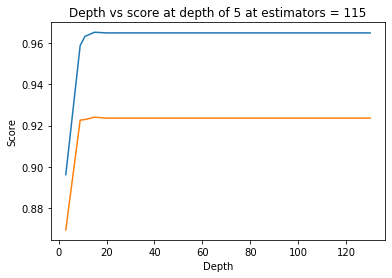

In [96]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_train))
    test_sc = f1_score(y_test,clf.predict(df_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

## Random model in RandomForest assigning both estimator and depth in hyperparamter tuning  

In [101]:
param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}
clf=RandomForestClassifier(random_state=25,n_jobs=1)
rf_random=RandomizedSearchCV(clf,param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)
rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
#print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [1. 1. 1. 1. 1.]


In [102]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=51, min_samples_split=125,
                       min_weight_fraction_leaf=0.0, n_estimators=117, n_jobs=1,
                       oob_score=False, random_state=25, verbose=0,
                       warm_start=False)


In [103]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [104]:
clf.fit(df_train,y_train)
y_train_pred = clf.predict(df_train)
y_test_pred = clf.predict(df_test)

In [105]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9648275722741874
Test f1 score 0.9238008820612378


Train confusion_matrix


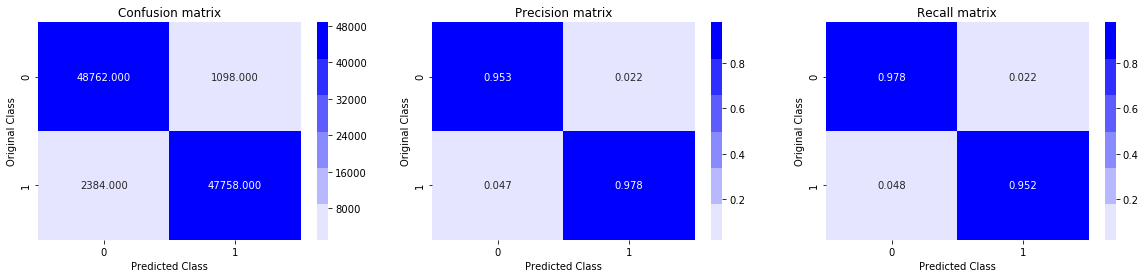

Test confusion_matrix


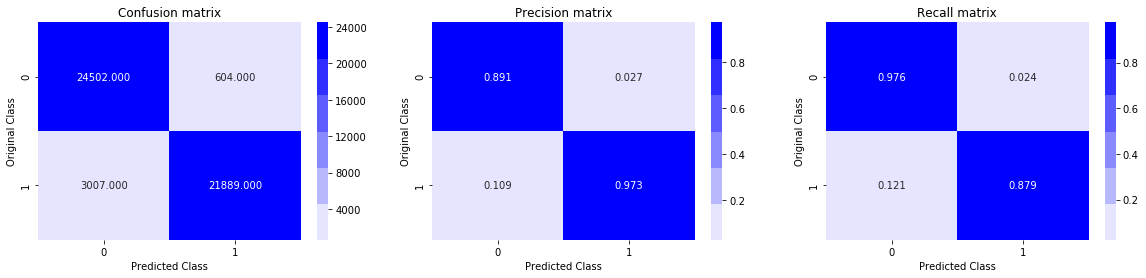

In [109]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

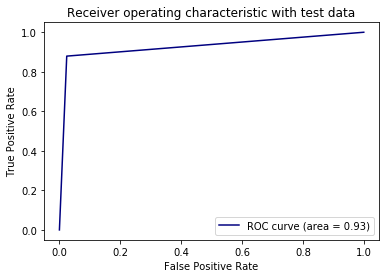

In [110]:
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

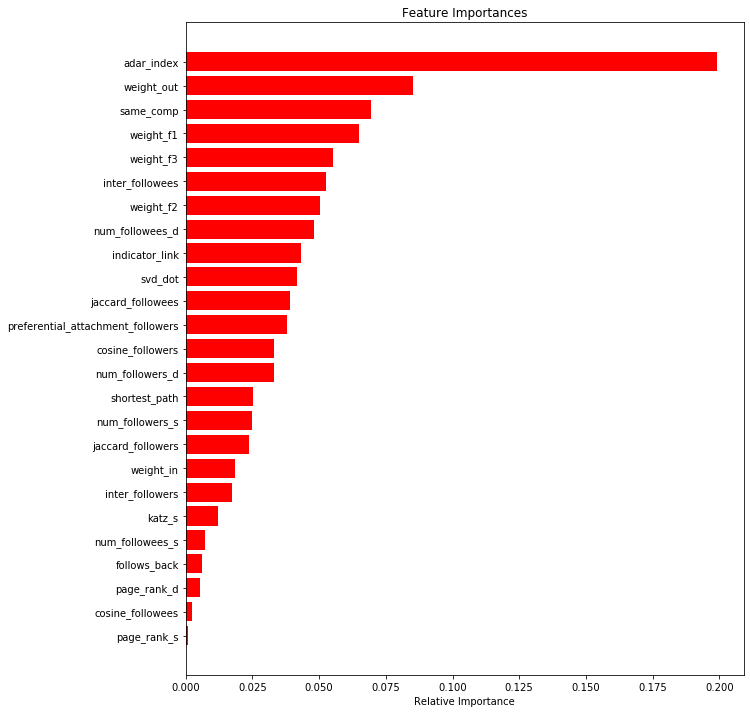

In [98]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Logistic Regression

Estimators =  0.0001 Train Score 0.21707351688901505 test Score 0.21305718790311023
Estimators =  0.001 Train Score 0.5437395694699706 test Score 0.5409846560959475
Estimators =  0.01 Train Score 0.6125164082733174 test Score 0.6109221128021486
Estimators =  0.1 Train Score 0.5587252941951085 test Score 0.5491361875289359
Estimators =  1 Train Score 0.6721767194619224 test Score 0.6670836165873556
Estimators =  10 Train Score 0.6832632745041505 test Score 0.6713739874675225
Estimators =  100 Train Score 0.2346086346086346 test Score 0.22898704984921056


Text(0.5, 1.0, 'alpha vs score at depth of 5')

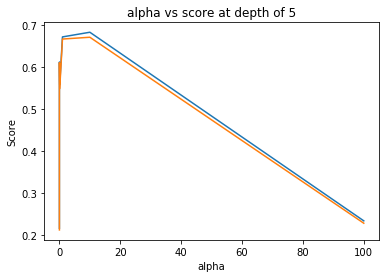

In [121]:
param=[10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2]
train_scores=[]
test_scores=[]
for i in param:
    clf=SGDClassifier(loss="log",alpha=i,penalty='l2',max_iter=1000,n_jobs=1)
    train=clf.fit(df_train,y_train)
    train_predict=clf.predict(df_train)
    test_predict=clf.predict(df_test)
    train_scr=f1_score(y_train,train_predict)
    test_scr=f1_score(y_test,test_predict)
    test_scores.append(test_scr)
    train_scores.append(train_scr)
    print('Estimators = ',i,'Train Score',train_scr,'test Score',test_scr)
plt.plot(param,train_scores,label='Train Score')
plt.plot(param,test_scores,label='Test Score')
plt.xlabel('alpha')
plt.ylabel('Score')
plt.title('alpha vs score at depth of 5')

In [142]:
best_alpha=1
clf=SGDClassifier(alpha=1,loss="log",penalty="l2")
train=clf.fit(df_train,y_train)
train_predict=clf.predict(df_train)
test_predict=clf.predict(df_test)
train_scr=f1_score(y_train,train_predict)
test_scr=f1_score(y_test,test_predict)
print("Train_score:",train_scr)
print("Test_score:",test_scr)

Train_score: 0.6761575287416571
Test_score: 0.6717623751246996


Train confusion_matrix


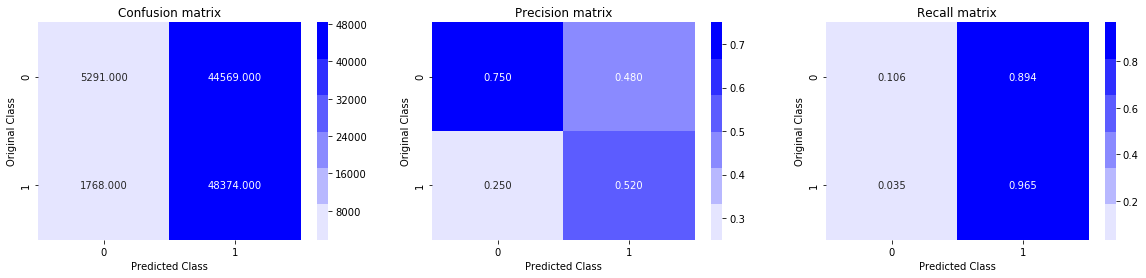

Test confusion_matrix


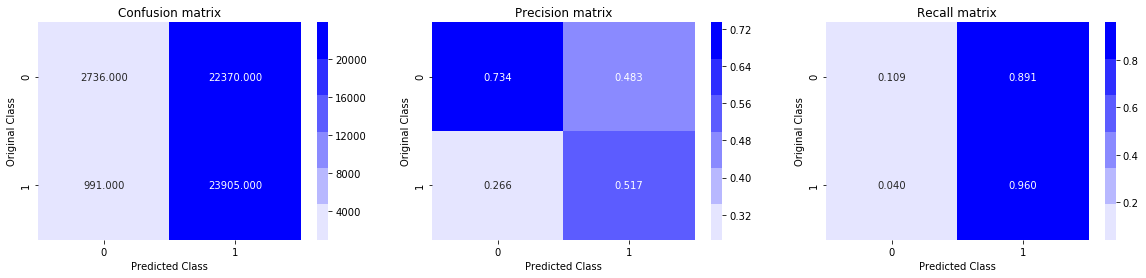

In [143]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,train_predict)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,test_predict)

# Xgboost 

Estimators =  100 depth 10 Train Score 1.0 test Score 0.9249300557418362
Estimators =  150 depth 15 Train Score 1.0 test Score 0.9256667377853637
Estimators =  200 depth 20 Train Score 1.0 test Score 0.9273831078922142
Estimators =  250 depth 25 Train Score 1.0 test Score 0.927229346853564
Estimators =  300 depth 30 Train Score 1.0 test Score 0.9275337621948622
Estimators =  400 depth 35 Train Score 1.0 test Score 0.9273602590320381


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

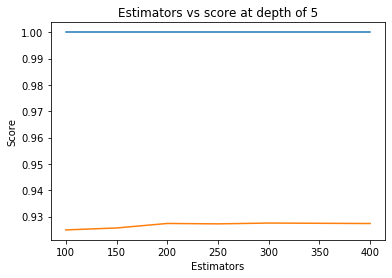

In [111]:
estimator=[100,150,200,250,300,400]
depth=[10,15,20,25,30,35]
train_score=[]
test_score=[]
for i,j in zip(estimator,depth):
    clf=xgboost.XGBClassifier(n_estimators=i,max_depth=j,njobs=1)
    train=clf.fit(df_train,y_train)
    train_predict=clf.predict(df_train)
    test_predict=clf.predict(df_test)
    train_score.append(f1_score(y_train,train_predict))
    test_score.append(f1_score(y_test,test_predict))
    print('Estimators = ',i,"depth",j,'Train Score',f1_score(y_train,train_predict),'test Score',f1_score(y_test,test_predict))
plt.plot(estimator,train_score,label='Train Score')
plt.plot(estimator,test_score,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')
    

Train confusion_matrix


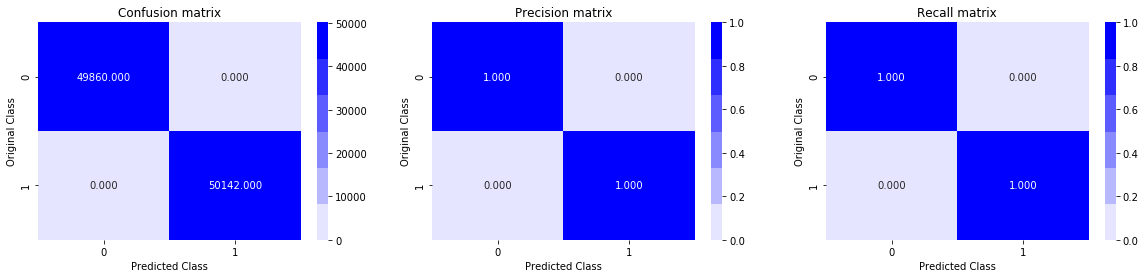

Test confusion_matrix


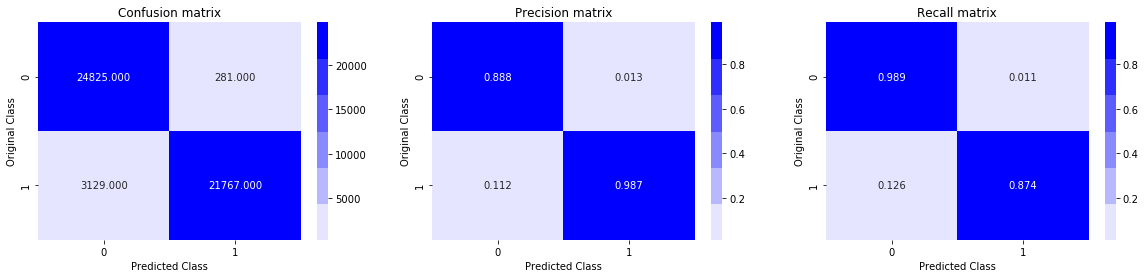

In [112]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,train_predict)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,test_predict)

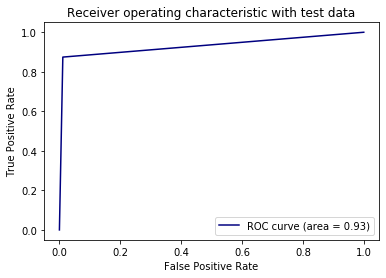

In [113]:
fpr,tpr,ths = roc_curve(y_test,test_predict)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

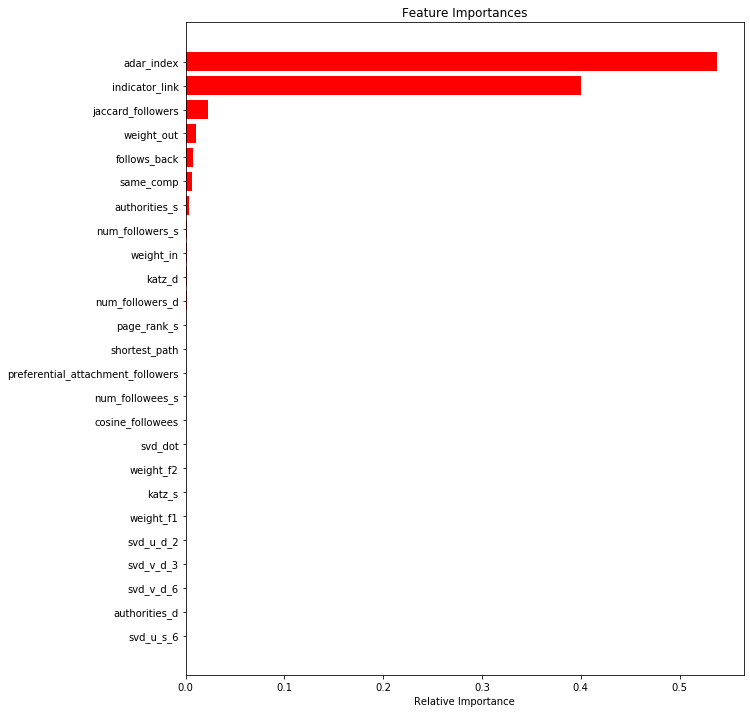

In [114]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# conclusion

1. First loading the dataset which the dataset consist of two features.They are source node and Destination nodes
2. Next we are using the networkx to find the nodes and edges in the dataset.
3. Applying Exploratory data Analysis here doing analysis on no of followers and followees uisng nodes and directed edges
4. Applying the Featurization Part here we use various importance features to get better performance in the model.
5. Train Test split we here randomly split the train and test split which we are randomly picking up therefore we have 1L train datapoints and 50k test datapoints.
6. At the model implement stage we are applying the Randomforest model  and Xgboost with different estimators and depth using the hyperparameter tuning and we are selecting right hyperparameter for applying the test datapoints.
7. we are using confusion matrix and F1 score thus we are ploting confusion matrix and F1score
8. Finally we applied Feature importance for both the model and plotted in the bar graph


